<a href="https://colab.research.google.com/github/Jaeyoung0209/GenderClassify/blob/main/Gender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from glob import glob
import os
import cv2
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from datetime import datetime
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import losses
import dlib
detector = dlib.get_frontal_face_detector()
base_path = 'drive/MyDrive/Gender'

In [ ]:
m_imgs = []
f_imgs = []

for filename in os.listdir(os.path.join(base_path, 'Validation/male')):
  m_imgs.append(cv2.imread(os.path.join(base_path, 'Validation/male', filename)))

for filename in os.listdir(os.path.join(base_path, 'Validation/female')):
  f_imgs.append(cv2.imread(os.path.join(base_path, 'Validation/female', filename)))

print(len(m_imgs))
print(len(f_imgs))

(102, 81)


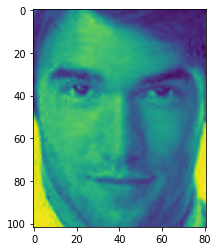

In [ ]:
img = cv2.imread('drive/MyDrive/Gender/Validation/male/090534.jpg.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
print(img.shape)
plt.imshow(img)

In [ ]:
def resize(img):
  faces = detector(img, 1)
  for face in faces:
    x, y, w, h = face.left(), face.top(), face.width(), face.height()

    if x < 0:
      x = 0
    if y < 0:
      y = 0

    img = img[y:y+h, x:x+w]

  ww = 85
  hh = 110
  if img.shape[1] > ww:
      img = img[0:1000, int((img.shape[1]-ww)/2):int(img.shape[1]-(img.shape[1]-ww)/2)]
  if img.shape[0] > hh:
      img = img[int((img.shape[0]-hh)/2):int(img.shape[0]-(img.shape[0]-hh)/2), 0:1000]

  ht, wd, cc= img.shape
  color = (0,0,0)
  result = np.full((hh,ww,cc), color, dtype=np.uint8)

  xx = (ww - wd) // 2
  yy = (hh - ht) // 2

  result[yy:yy+ht, xx:xx+wd] = img
  return result

In [ ]:
data = np.load(os.path.join(base_path, 'males.npy'))
print(data.shape)

(5808, 110, 85, 3)


In [ ]:
m_imgs = []

i = 0

for filename in os.listdir(os.path.join(base_path, 'Validation/male')):
  img = cv2.imread(os.path.join(base_path, 'Validation/male', filename))
  result = resize(img)
  m_imgs.append(result)
  i += 1
  print(i)


m_imgs = np.array(m_imgs)
np.save(os.path.join(base_path, 'males.npy'), m_imgs)



In [ ]:
f_imgs = []

i = 0

for filename in os.listdir(os.path.join(base_path, 'Validation/female')):
  img = cv2.imread(os.path.join(base_path, 'Validation/female', filename))

  result = resize(img)
  f_imgs.append(result)
  i += 1
  print(i)


f_imgs = np.array(f_imgs)
np.save(os.path.join(base_path, 'females.npy'), f_imgs)

In [ ]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

males = np.load(os.path.join(base_path, 'males.npy'))
females = np.load(os.path.join(base_path, 'females.npy'))

x_data = np.concatenate((males, females))


males_label = np.zeros((males.shape[0]))
females_label = np.ones((females.shape[0]))

labels = np.concatenate((males_label, females_label))



X_train, X_test, y_train, y_test = train_test_split(x_data, labels, test_size=0.20, random_state=42)

X_train, y_train = unison_shuffled_copies(X_train, y_train)

np.save(os.path.join(base_path, 'x_train.npy'), X_train)
np.save(os.path.join(base_path, 'x_test.npy'), X_test)
np.save(os.path.join(base_path, 'y_train.npy'), y_train)
np.save(os.path.join(base_path, 'y_test.npy'), y_test)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical, plot_model

x_train = np.load(os.path.join(base_path, 'x_train.npy'))
y_train = np.load(os.path.join(base_path, 'y_train.npy'))
x_val = np.load(os.path.join(base_path, 'x_test.npy'))
y_val = np.load(os.path.join(base_path, 'y_test.npy'))

x_train = np.array(x_train, dtype="float") / 255.0
x_val = np.array(x_val, dtype="float") / 255.0

y_train = to_categorical(y_train, num_classes=2)
y_val = to_categorical(y_val, num_classes=2)

aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
                         height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
                         horizontal_flip=True, fill_mode="nearest")

In [ ]:
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
from tensorflow.keras import backend as K
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
img_dims = (110, 85, 3)
lr = 1e-3
epochs = 20
batch_size = 32
def build(width, height, depth, classes):
    model = Sequential()
    inputShape = (height, width, depth)
    chanDim = -1

    if K.image_data_format() == "channels_first": #Returns a string, either 'channels_first' or 'channels_last'
        inputShape = (depth, height, width)
        chanDim = 1

    # The axis that should be normalized, after a Conv2D layer with data_format="channels_first",
    # set axis=1 in BatchNormalization.

    model.add(Conv2D(32, (3,3), padding="same", input_shape=inputShape))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(3,3)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))

    model.add(Conv2D(64, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))

    model.add(Conv2D(128, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(classes))
    model.add(Activation("sigmoid"))

    return model

model = build(width=img_dims[0], height=img_dims[1], depth=img_dims[2],
                            classes=2)

# compile the model
opt = Adam(lr=lr, decay=lr/epochs)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

In [ ]:
tf.config.run_functions_eagerly(True)

H = model.fit_generator(aug.flow(x_train, y_train, batch_size=batch_size),
                        validation_data=(x_val,y_val),
                        steps_per_epoch=len(x_train) // batch_size,
                        epochs=epochs, verbose=1)

# save the model to disk
model.save(os.path.join(base_path,'model/gender_detection.h5'))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


Epoch 1/20
291/291 [==============================] - 67s 229ms/step - loss: 0.7607 - accuracy: 0.6767 - val_loss: 1.2289 - val_accuracy: 0.5021
Epoch 2/20
291/291 [==============================] - 64s 220ms/step - loss: 0.4421 - accuracy: 0.8219 - val_loss: 1.1630 - val_accuracy: 0.6155
Epoch 3/20
291/291 [==============================] - 64s 219ms/step - loss: 0.3238 - accuracy: 0.8738 - val_loss: 0.1895 - val_accuracy: 0.9309
Epoch 4/20
291/291 [==============================] - 63s 218ms/step - loss: 0.2569 - accuracy: 0.8972 - val_loss: 0.2480 - val_accuracy: 0.9133
Epoch 5/20
291/291 [==============================] - 63s 217ms/step - loss: 0.2284 - accuracy: 0.9080 - val_loss: 0.2554 - val_accuracy: 0.9090
Epoch 6/20
291/291 [==============================] - 61s 210ms/step - loss: 0.2087 - accuracy: 0.9194 - val_loss: 0.2887 - val_accuracy: 0.8841
Epoch 7/20
291/291 [==============================] - 62s 213ms/step - loss: 0.2018 - accuracy: 0.9222 - val_loss: 0.1535 - val_ac

In [ ]:
train_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255)

train_dir = os.path.join(base_path, 'Training')
validation_dir = os.path.join(base_path, 'Validation')


model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation="relu", input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(32, (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(64, (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(64, (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation="relu"),
    tf.keras.layers.Dense(84, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])


training_generator = train_datagen.flow_from_directory(train_dir,
                                                      target_size=(300, 300),
                                                      batch_size=20,
                                                      class_mode="binary")

validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                       target_size=(300, 300),
                                                       batch_size=20,
                                                       class_mode="binary")

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
history = model.fit_generator(training_generator, steps_per_epoch=100, epochs=30,
                    validation_data=validation_generator,
                    validation_steps=50,
                    verbose=1)

Found 9318 images belonging to 2 classes.
Found 2331 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 754s 8s/step - loss: 0.7714 - accuracy: 0.5770 - val_loss: 0.4320 - val_accuracy: 0.8070
Epoch 2/30
100/100 [==============================] - 524s 5s/step - loss: 0.4503 - accuracy: 0.7942 - val_loss: 0.4146 - val_accuracy: 0.8260
Epoch 3/30
100/100 [==============================] - 383s 4s/step - loss: 0.4071 - accuracy: 0.8198 - val_loss: 0.2753 - val_accuracy: 0.8830
Epoch 4/30
100/100 [==============================] - 293s 3s/step - loss: 0.3021 - accuracy: 0.8706 - val_loss: 0.2922 - val_accuracy: 0.8810
Epoch 5/30
100/100 [==============================] - 217s 2s/step - loss: 0.2672 - accuracy: 0.8893 - val_loss: 0.2783 - val_accuracy: 0.8830
Epoch 6/30
100/100 [==============================] - 184s 2s/step - loss: 0.2177 - accuracy: 0.9098 - val_loss: 0.2534 - val_accuracy: 0.9020
Epoch 7/30
100/100 [==============================] - 143s

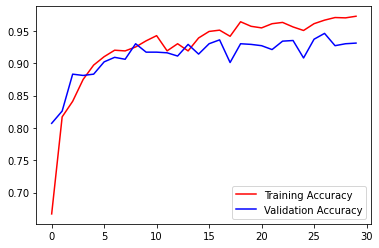

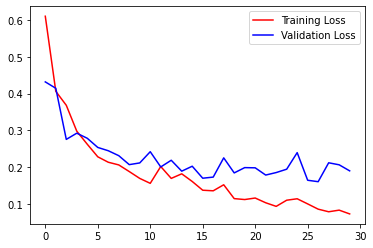

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(len(acc))

plt.plot(epochs, acc, "r", label="Training Accuracy")
plt.plot(epochs, val_acc, "b", label="Validation Accuracy")

plt.legend()
plt.figure()

plt.plot(epochs, loss, "r", label="Training Loss")
plt.plot(epochs, val_loss, "b", label="Validation Loss")

plt.legend()
plt.show()

In [ ]:
model.save(os.path.join(base_path, 'models/GenderCNN30030.h5'))

In [ ]:
def predict_gender(img):
  model = tf.keras.models.load_model(os.path.join(base_path, 'models/GenderCNN.h5'))

  faces = detector(img, 1)

  fig, ax = plt.subplots(1, figsize =(16, 10))

  for face in faces:
    x, y, w, h = face.left(), face.top(), face.width(), face.height()

    if x < 0:
      x = 0
    if y < 0:
      y = 0




    i = 0
    while True:
      if 85*i >= w and 85*(i-1) < w:
          break
      i+=1
    hh, ww = 110*i, 85*i
    ht, wd, cc= img[y:y+h, x:x+w].shape
    color = (0,0,0)
    result = np.full((hh,ww,cc), color, dtype=np.uint8)

    xx = (ww - wd) // 2
    yy = (hh - ht) // 2
    print(result[yy:yy+ht, xx:xx+wd].shape)
    result[yy:yy+ht, xx:xx+wd] = img[y:y+h, x:x+w]
    result = cv2.resize(result, (85, 110))
    print(result.shape)
    output = model.predict(np.expand_dims(resize(result), axis = 0))
    print(output)
    plt.imshow(result)
  #   rectangle = patches.Rectangle((x, y), w, h, linewidth = 2, edgecolor = 'r', facecolor = 'none')
  #   ax.add_patch(rectangle)

  #   print(output)

  # ax.imshow(img)

In [ ]:
img = cv2.imread('drive/MyDrive/Gender/Validation/male/090534.jpg.jpg')
predict_gender(img)

In [ ]:
img = cv2.imread('drive/MyDrive/Gender/face.jpg')

predict_gender(img)

In [ ]:
from keras.preprocessing import image

img = cv2.imread(os.path.join(base_path, 'male.png'))
faces = detector(img, 1)

for face in faces:
  x, y, w, h = face.left(), face.top(), face.width(), face.height()

  if x < 0:
    x = 0
  if y < 0:
    y = 0

img = img[y:y+h, x:x+w]

cv2.imwrite(os.path.join(base_path, 'temp.jpg'), img)

img = image.load_img(os.path.join(base_path, 'temp.jpg'), target_size=(300, 300))
x = image.img_to_array(img)
plt.imshow(img)
x = np.expand_dims(img, axis=0)

images_show = np.vstack([x])
model = tf.keras.models.load_model(os.path.join(base_path, 'models/GenderCNN30030.h5'))

predict_classes = model.predict(images_show, batch_size=10)

if predict_classes == 1:
  print('male')
else:
  print('female')

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [ ]:
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;

    var pendingResolve = null;
    var shutdown = false;

    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }

    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }

    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);

      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);

      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);

      const instruction = document.createElement('div');
      instruction.innerHTML =
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };

      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);

      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();

      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }

      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }

      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;

      return {'create': preShow - preCreate,
              'show': preCapture - preShow,
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)

def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [ ]:
import PIL
import io
import html
from keras.preprocessing import image
import time
from google.colab.output import eval_js
from base64 import b64decode, b64encode

import warnings
warnings.filterwarnings("ignore")

# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0
gender = ''
model = tf.keras.models.load_model(os.path.join(base_path, 'models/GenderCNN30030.h5'))

while True:
  js_reply = video_frame(label_html, bbox)
  if not js_reply:
      break

  # convert JS response to OpenCV Image
  img = js_to_image(js_reply["img"])

  bbox_array = np.zeros([480,640,4], dtype=np.uint8)
  # create transparent overlay for bounding box
  try:
    faces = detector(img, 1)
    for face in faces:
      x, y, w, h = face.left(), face.top(), face.width(), face.height()
      bbox_array = cv2.rectangle(bbox_array,(x,y),(x+w,y+h),(255,0,0),2)
      cv2.putText(bbox_array, gender, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255,0,0), 2)
      temp = img[y:y+h, x:x+w]


      temp = cv2.resize(temp, (300, 300))
      x1 = np.expand_dims(temp, axis=0)

      images_show = np.vstack([x1])

      predict_classes = model.predict(images_show, batch_size=10, verbose = 0)

      if predict_classes == 1:
        gender = 'male'

      else:
        gender = 'female'




    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes
  except:
    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes